## Embedding speed testing

We will try to increse the embedding speed on CPU as fast as possible.

In [1]:
%%capture
!pip install transformers
!pip install -U sentence-transformers
!pip install pyvi
!pip install langchain-community
!pip install torch

In [2]:
%%capture
!pip install transformers[onnx] torch

In [3]:
query = "Deep Learning là gì và nó có những ứng dụng nào?"

docs = [
    # Đoạn văn liên quan nhất
    "Deep Learning là một nhánh của học máy, sử dụng các mạng nơ-ron sâu để mô hình hóa và giải quyết các vấn đề phức tạp. "
    "Nó có nhiều ứng dụng trong thực tế như nhận diện hình ảnh, xử lý ngôn ngữ tự nhiên, và chẩn đoán y tế.",

    # Đoạn văn không liên quan 1
    "Trong thiên văn học, việc khám phá các hành tinh ngoài hệ Mặt Trời là một trong những lĩnh vực nghiên cứu sôi động nhất. "
    "Các nhà khoa học sử dụng kính viễn vọng và các phương pháp đo lường hiện đại để tìm kiếm và phân tích các hành tinh mới.",

    # Đoạn văn không liên quan 2
    "Ẩm thực Việt Nam nổi tiếng với sự phong phú và đa dạng, từ các món phở, bún chả đến các món ăn đường phố như bánh mì và nem rán. "
    "Các nguyên liệu tươi ngon và cách chế biến đặc trưng tạo nên hương vị độc đáo.",

    # Đoạn văn trung bình 1
    "Mạng nơ-ron nhân tạo là một cấu trúc cơ bản trong học máy, bao gồm các nút và liên kết. "
    "Chúng được sử dụng để phân tích và dự đoán dữ liệu, và có thể được áp dụng trong nhiều lĩnh vực khác nhau.",

    # Đoạn văn trung bình 2
    "Trí tuệ nhân tạo đang thay đổi cách chúng ta sống và làm việc. "
    "Nó không chỉ cải thiện hiệu suất trong các ngành công nghiệp mà còn giúp giải quyết các vấn đề phức tạp như phát hiện gian lận và tối ưu hóa logistics."
]

### Pytorch format

In [4]:
from sentence_transformers import SentenceTransformer
import torch

halong_embed = SentenceTransformer("hiieu/halong_embedding")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/201 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/13.9k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/749 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.34k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

In [5]:
from langchain.embeddings.base import Embeddings
class CustomEmbeddings(Embeddings):
    def __init__(self, model):
        self.model = model

    def embed_documents(self, texts):
        return self.model.encode(texts)

    def embed_query(self, text):
        return self.model.encode([text])[0]

In [6]:
halong_pt = CustomEmbeddings(halong_embed)

In [7]:
import time

start_time = time.time()
b = halong_pt.embed_documents(docs)
end_time = time.time()

print("Embedidng time: ", end_time - start_time)

Embedidng time:  1.2990624904632568


### Onnx format

In [9]:
from sentence_transformers import SentenceTransformer
import torch
from transformers import AutoTokenizer

# Load the model
model_name = "hiieu/halong_embedding"
model = SentenceTransformer(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Prepare dummy input
dummy_text = ["This is a sample sentence."]
encoded_input = tokenizer(dummy_text, padding=True, truncation=True, return_tensors="pt")

# Define a wrapper class to make the model ONNX-exportable
class ONNXWrapper(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, input_ids, attention_mask, token_type_ids=None):
        features = {'input_ids': input_ids, 'attention_mask': attention_mask}
        if token_type_ids is not None:
            features['token_type_ids'] = token_type_ids
        return self.model(features)['sentence_embedding']

# Wrap the model
wrapped_model = ONNXWrapper(model)

# Set the output path
output_path = "halong_embedding.onnx"

# Export the model to ONNX
torch.onnx.export(
    wrapped_model,
    (encoded_input['input_ids'], encoded_input['attention_mask']),
    output_path,
    input_names=['input_ids', 'attention_mask'],
    output_names=['sentence_embedding'],
    dynamic_axes={
        'input_ids': {0: 'batch_size', 1: 'sequence_length'},
        'attention_mask': {0: 'batch_size', 1: 'sequence_length'},
        'sentence_embedding': {0: 'batch_size'}
    },
    opset_version=14
)

print(f"Model exported to {output_path}")

Model exported to halong_embedding.onnx


In [10]:
%%capture
!pip install onnxruntime
!pip install scikit-learn

In [11]:
import onnxruntime as ort
ort_session = ort.InferenceSession("halong_embedding.onnx")

model_name = "hiieu/halong_embedding"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [12]:
import numpy as np
import onnxruntime as ort
from transformers import AutoTokenizer
from sklearn.metrics.pairwise import cosine_similarity

ort_session = ort.InferenceSession("halong_embedding.onnx", providers=['CPUExecutionProvider'])

model_name = "hiieu/halong_embedding"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def encode(texts):
    encoded_input = tokenizer(texts, padding=True, truncation=True, return_tensors="np")
    model_inputs = {
        'input_ids': encoded_input['input_ids'],
        'attention_mask': encoded_input['attention_mask']
    }
    outputs = ort_session.run(None, model_inputs)

    return outputs[0]

def cosine_sim(a, b):
    return cosine_similarity(a.reshape(1, -1), b.reshape(1, -1))[0][0]

sentence1 = "Hôm nay trời đẹp quá."
sentence2 = "Thời tiết hôm nay thật tuyệt vời."

embedding1 = encode([sentence1])
embedding2 = encode([sentence2])

similarity = cosine_sim(embedding1, embedding2)

print(f"Câu 1: {sentence1}")
print(f"Câu 2: {sentence2}")
print(f"Độ tương đồng cosine: {similarity:.4f}")

Câu 1: Hôm nay trời đẹp quá.
Câu 2: Thời tiết hôm nay thật tuyệt vời.
Độ tương đồng cosine: 0.7792


In [13]:
import time
import numpy as np
import matplotlib.pyplot as plt

def run_benchmark(embed_func, docs, name, num_runs=5):
    times = []
    for _ in range(num_runs):
        start_time = time.time()
        embed_func(docs)
        end_time = time.time()
        times.append(end_time - start_time)
    return times

num_runs = 5
pt_times = run_benchmark(halong_embed.encode, docs, "PyTorch", num_runs)
onnx_times = run_benchmark(encode, docs, "ONNX", num_runs)

# Tính thời gian trung bình
pt_avg = np.mean(pt_times)
onnx_avg = np.mean(onnx_times)

print(f"PyTorch average time: {pt_avg:.4f} seconds")
print(f"ONNX average time: {onnx_avg:.4f} seconds")

PyTorch average time: 2.3360 seconds
ONNX average time: 2.0077 seconds


In [14]:
import onnxruntime as ort
print(ort.__version__)

1.20.1


In [16]:
import onnx
model_path = '/content/halong_embedding.onnx'
try:
    model = onnx.load(model_path)
    onnx.checker.check_model(model)
    print("Mô hình hợp lệ.")
except onnx.checker.ValidationError as e:
    print(f"Mô hình không hợp lệ: {e}")

Mô hình hợp lệ.


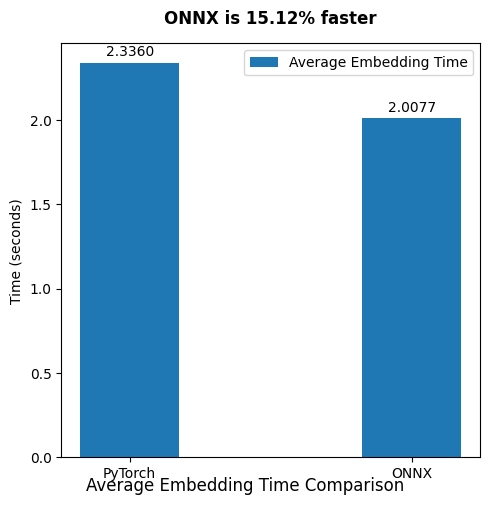

In [17]:
labels = ['PyTorch', 'ONNX']
averages = [pt_avg, onnx_avg]
x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(5, 5))
rects = ax.bar(x, averages, width, label='Average Embedding Time')
fig.text(0.5, 0.02, 'Average Embedding Time Comparison', ha='center', va='center', fontsize=12)

ax.set_ylabel('Time (seconds)')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Thêm nhãn giá trị trên mỗi cột
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects)

# Thêm phần trăm chênh lệch
percent_diff = abs(pt_avg - onnx_avg) / ((pt_avg + onnx_avg) / 2) * 100
faster = "ONNX" if onnx_avg < pt_avg else "PyTorch"
ax.text(0.5, max(averages) * 1.1, f"{faster} is {percent_diff:.2f}% faster",
        horizontalalignment='center', fontsize=12, fontweight='bold')

fig.tight_layout()
plt.show()

In [18]:

from transformers import AutoTokenizer
from langchain.embeddings.base import Embeddings
import onnxruntime as ort

class CustomEmbeddings(Embeddings):
    def __init__(self, model_path, model_name):
        self.ort_session = ort.InferenceSession(model_path, providers=['CPUExecutionProvider'])
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)

    def encode(self, texts):
        encoded_input = self.tokenizer(texts, padding=True, truncation=True, return_tensors="np")
        model_inputs = {
            'input_ids': encoded_input['input_ids'],
            'attention_mask': encoded_input['attention_mask']
        }
        outputs = self.ort_session.run(None, model_inputs)
        return outputs[0]

    def embed_documents(self, texts):
        return self.encode(texts)

    def embed_query(self, text):
        return self.encode([text])[0]

# Sử dụng lớp CustomEmbeddings
model_path = "halong_embedding.onnx"
model_name = "hiieu/halong_embedding"

embedding_model = CustomEmbeddings(model_path, model_name)
documents_embeddings = embedding_model.embed_documents(docs)
print(documents_embeddings)


[[-0.02660262 -0.00367526  0.03846518 ...  0.02842513  0.05120032
   0.04688334]
 [-0.08080775 -0.00362959  0.02110818 ... -0.00407529 -0.00960043
  -0.00711809]
 [-0.00408288  0.08815017 -0.0008076  ... -0.01386027  0.01440743
   0.00345555]
 [-0.01799247 -0.04160569  0.01657778 ... -0.00952344  0.02974878
   0.03099742]
 [-0.00882846  0.06982823  0.02563423 ...  0.07979378  0.00780862
  -0.00772423]]
